In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

In [3]:
num_classes = len(set(y_train))

print(f'카테고리 : {num_classes}')
print(f'훈련용 리뷰 개수 : {len(X_train)}')
print(f'테스트용 리뷰 개수 : {len(X_test)}')

카테고리 : 2
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


In [4]:
reviews_length = [len(review) for review in X_train]

In [5]:
print(f'리뷰의 최대 길이 : {np.max(reviews_length)}')
print(f'리뷰의 평균 길이 : {np.max(reviews_length)}')

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 2494


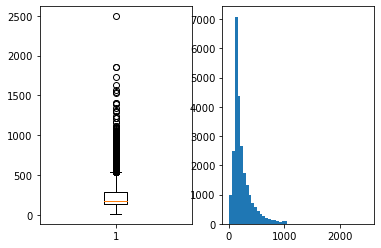

In [6]:
# 데이터 분포 시각화 
plt.subplot(1,2,1)
plt.boxplot(reviews_length)
plt.subplot(1,2,2)
plt.hist(reviews_length, bins=50)
plt.show()

In [7]:
label, counts = np.unique(y_train, return_counts=True)
print("[ 레이블별 빈도수 ]")
print(np.asarray((label, counts)))

[ 레이블별 빈도수 ]
[[    0     1]
 [12500 12500]]


In [8]:
# get_word_index() => 각 단어와 맵핑되는 정수 가져오기
word_to_index = imdb.get_word_index()

# 전처리 전에 단어 저장
index_to_word = {}
for key, value in word_to_index.items():
    # imdb의 경우 4번 인덱스 부터 데이터 
    index_to_word[value+3] = key

In [9]:
print(f'빈도수 상위   1번째 단어 : {index_to_word[4]}')
print(f'빈도수 상위 100번째 단어 : {index_to_word[100]}')

빈도수 상위   1번째 단어 : the
빈도수 상위 100번째 단어 : could


####  단어사전 단어수 설정 데이터 로딩

In [10]:
VOCA_SIZE = 10000
PAD_LEN = 500

In [12]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCA_SIZE)

X_train = pad_sequences(X_train, maxlen=PAD_LEN)
X_test = pad_sequences(X_test, maxlen=PAD_LEN)

### 모델 생성

In [13]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
EMB_DIM=100
HIDDEN_NODE=128

In [15]:
model = Sequential()
model.add(Embedding(VOCA_SIZE, EMB_DIM, input_length=PAD_LEN))
model.add(GRU(HIDDEN_NODE))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


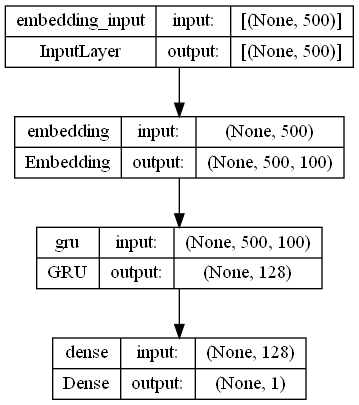

In [16]:
plot_model(model, show_shapes=True)

In [17]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [18]:
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=4)

mc = ModelCheckpoint('GRU_model.h5',
                     monitor='val_acc', 
                     mode='max', 
                     verbose=1, save_best_only=True)



In [19]:
history = model.fit(X_train, y_train, 
                    epochs=15, 
                    callbacks=[es, mc], 
                    batch_size=64, 
                    validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4812 - acc: 0.7551
Epoch 1: val_acc improved from -inf to 0.85500, saving model to GRU_model.h5
313/313 [==============================] - 246s 777ms/step - loss: 0.4812 - acc: 0.7551 - val_loss: 0.3506 - val_acc: 0.8550
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.2697 - acc: 0.8931
Epoch 2: val_acc improved from 0.85500 to 0.87620, saving model to GRU_model.h5
313/313 [==============================] - 386s 1s/step - loss: 0.2697 - acc: 0.8931 - val_loss: 0.3192 - val_acc: 0.8762
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.1838 - acc: 0.9316
Epoch 3: val_acc did not improve from 0.87620
313/313 [==============================] - 300s 959ms/step - loss: 0.1838 - acc: 0.9316 - val_loss: 0.3672 - val_acc: 0.8560
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.1288 - acc: 0.9553
Epoch 4: val_acc did not improve from 0.87620
313/313 [======

#### 예측

In [28]:
from tensorflow.keras.models import load_model

loaded_model = load_model('GRU_model.h5')

print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 96s 121ms/step - loss: 0.4315 - acc: 0.8669

 테스트 정확도: 0.8669


In [29]:
import re

def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encodeSent = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 사전 크기 VOCA_SIZE 10,000제한.
      if word_to_index[word] <= VOCA_SIZE:
        encodeSent.append(word_to_index[word]+3)
      else:
        # 10,000 이상의 숫자는 <unk> 토큰 변환.
        encodeSent.append(2)
        
    # 단어 사전에 없는 단어는 <unk> 토큰 변환.
    except KeyError:
      encodeSent.append(2)

  # 가변 > 고정 길이 설정 
  pad_sequence = pad_sequences([encodeSent], maxlen=PAD_LEN)
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print(f"{round(score * 100,2)}% 확률로 긍정 리뷰입니다.")
  else:
    print(f"{round((1 - score) * 100,2)}% 확률로 부정 리뷰입니다.")

In [30]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

1/1 [==============================] - 1s 1s/step
77.58% 확률로 부정 리뷰입니다.


### ConV

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
embedding_dim = 256   # 임베딩 벡터의 차원
dropout_ratio = 0.3   # 드롭아웃 비율
num_filters = 256     # 커널의 수
kernel_size = 3      # 커널의 크기
hidden_units = 128   # 뉴런의 수

In [2]:
# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

model.summary()

NameError: name 'vocab_size' is not defined

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[es, mc])